In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting styles
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


Missing values in each column:
 PJME_MW    0
dtype: int64


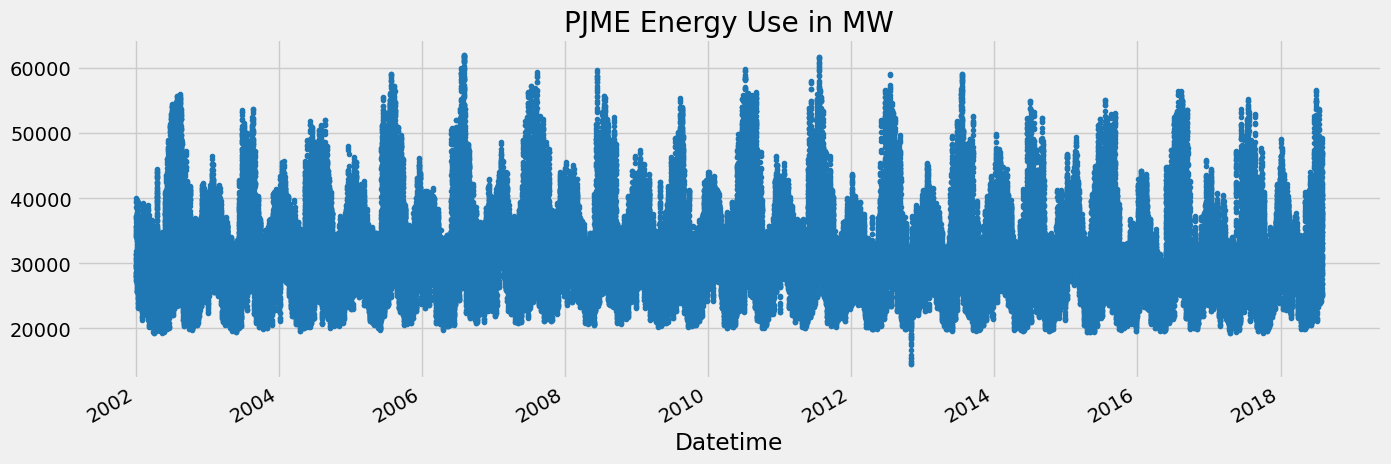

In [4]:
# Load the dataset
df = pd.read_csv('PJME_hourly.csv')

# Convert 'Datetime' to datetime object and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Fill missing values if any
df = df.fillna(method='ffill')

# Visualize the data
df['PJME_MW'].plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy Use in MW')
plt.show()

# Optional: Differencing to achieve stationarity (if needed)
# df['PJME_MW_diff'] = df['PJME_MW'] - df['PJME_MW'].shift(1)
# df = df.dropna()


In [5]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag1'] = df['PJME_MW'].shift(1)
    df['lag24'] = df['PJME_MW'].shift(24)
    df['lag168'] = df['PJME_MW'].shift(168)  # One week lag

    # Rolling statistics
    df['rolling_mean_24'] = df['PJME_MW'].rolling(window=24).mean()
    df['rolling_std_24'] = df['PJME_MW'].rolling(window=24).std()
    df['rolling_mean_168'] = df['PJME_MW'].rolling(window=168).mean()
    df['rolling_std_168'] = df['PJME_MW'].rolling(window=168).std()

    df = df.dropna()
    return df

# Apply the feature engineering function
df = create_features(df)


In [6]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag24,lag168,rolling_mean_24,rolling_std_24,rolling_mean_168,rolling_std_168
Datetime,,,,,,,,,,,,,,,,
2002-12-24 01:00:00,27213.0,1,1,4,12,2002,358,24,52,28570.0,27669.0,26498.0,29475.375000,2736.646326,30894.589286,3480.035908
2002-12-24 02:00:00,25643.0,2,1,4,12,2002,358,24,52,27213.0,26162.0,25147.0,29453.750000,2765.861628,30897.541667,3475.337816
2002-12-24 03:00:00,24907.0,3,1,4,12,2002,358,24,52,25643.0,25483.0,24574.0,29429.750000,2804.050165,30899.523810,3471.802781
2002-12-24 04:00:00,24721.0,4,1,4,12,2002,358,24,52,24907.0,25045.0,24393.0,29416.250000,2826.766154,30901.476190,3468.212273
2002-12-24 05:00:00,25144.0,5,1,4,12,2002,358,24,52,24721.0,25030.0,24860.0,29421.000000,2819.160745,30903.166667,3465.317909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,44343.0,45787.0,42112.0,40343.500000,2295.270146,41856.327381,3215.160350
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,44284.0,45209.0,40797.0,40282.750000,2177.148998,41873.910714,3217.409076
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,43751.0,43663.0,38819.0,40230.208333,2106.081917,41895.238095,3208.901743


In [7]:
# Split data into training and testing sets
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

# Define features and target
FEATURES = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'lag1', 'lag24', 'lag168', 'rolling_mean_24', 'rolling_std_24',
    'rolling_mean_168', 'rolling_std_168'
]
TARGET = 'PJME_MW'

# Prepare training and testing datasets
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]


In [8]:
# Define time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search model
random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", random_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1}


In [9]:
# Extract best parameters
best_params = random_search.best_params_

# Initialize XGBoost regressor with best parameters
reg = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    eval_metric='rmse',
    random_state=42
)

# Fit the model
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)


[0]	validation_0-rmse:6148.55119	validation_1-rmse:6217.17734
[100]	validation_0-rmse:720.26412	validation_1-rmse:795.33405
[200]	validation_0-rmse:602.11408	validation_1-rmse:692.57064
[300]	validation_0-rmse:556.52888	validation_1-rmse:654.63033
[400]	validation_0-rmse:523.62462	validation_1-rmse:630.47065
[500]	validation_0-rmse:500.06893	validation_1-rmse:613.06242
[600]	validation_0-rmse:481.51018	validation_1-rmse:602.02001
[700]	validation_0-rmse:467.61315	validation_1-rmse:594.71855
[800]	validation_0-rmse:454.56708	validation_1-rmse:588.91095
[900]	validation_0-rmse:443.81485	validation_1-rmse:583.47779
[999]	validation_0-rmse:433.92379	validation_1-rmse:578.79619


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=50, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
# Make predictions
test['prediction'] = reg.predict(X_test)

# Calculate residuals
test['residuals'] = test[TARGET] - test['prediction']

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
mae = mean_absolute_error(y_test, test['prediction'])
mape = mean_absolute_percentage_error(y_test, test['prediction'])

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape*100:.2f}%')


RMSE: 578.74
MAE: 359.91
MAPE: 1.17%


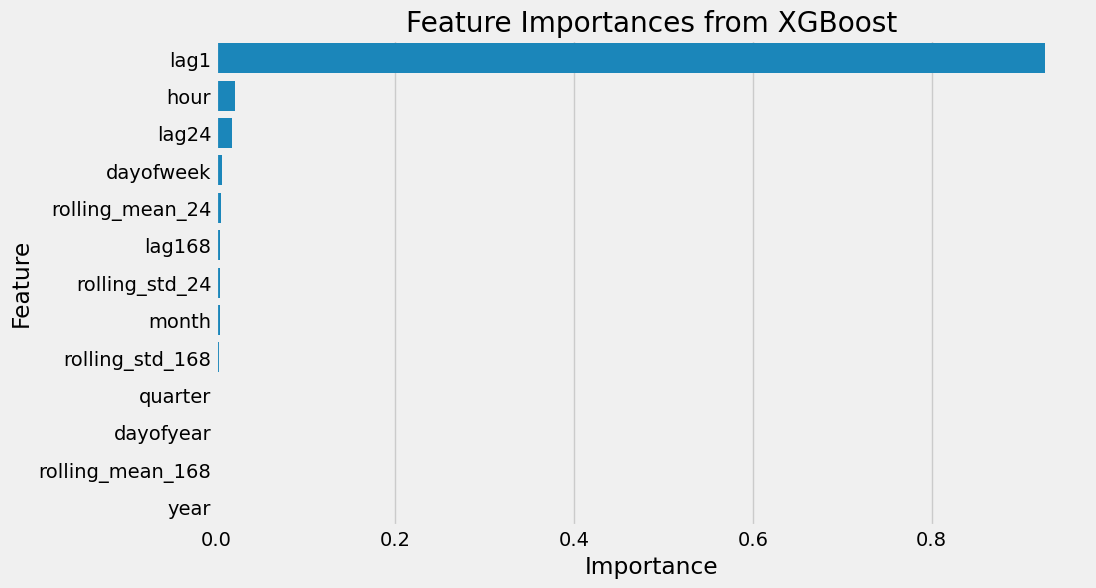

In [11]:
# Plot feature importances
fi = pd.DataFrame({
    'Feature': reg.feature_names_in_,
    'Importance': reg.feature_importances_
})
fi = fi.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi)
plt.title('Feature Importances from XGBoost')
plt.show()


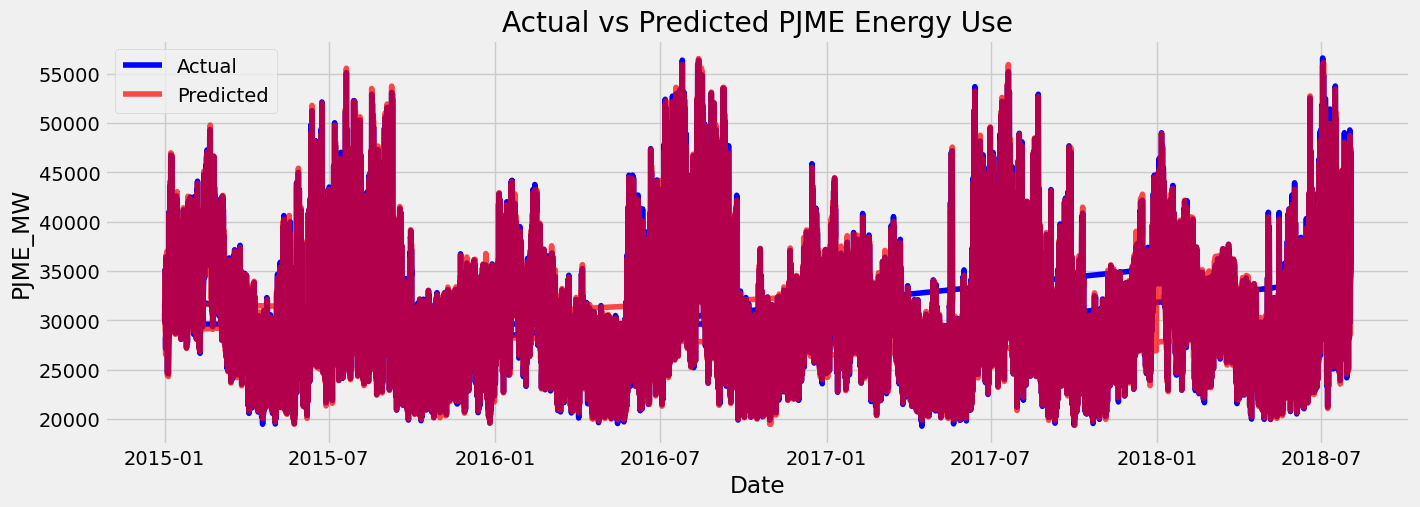

In [12]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Actual', color='b')
plt.plot(test.index, test['prediction'], label='Predicted', color='r', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted PJME Energy Use')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.show()


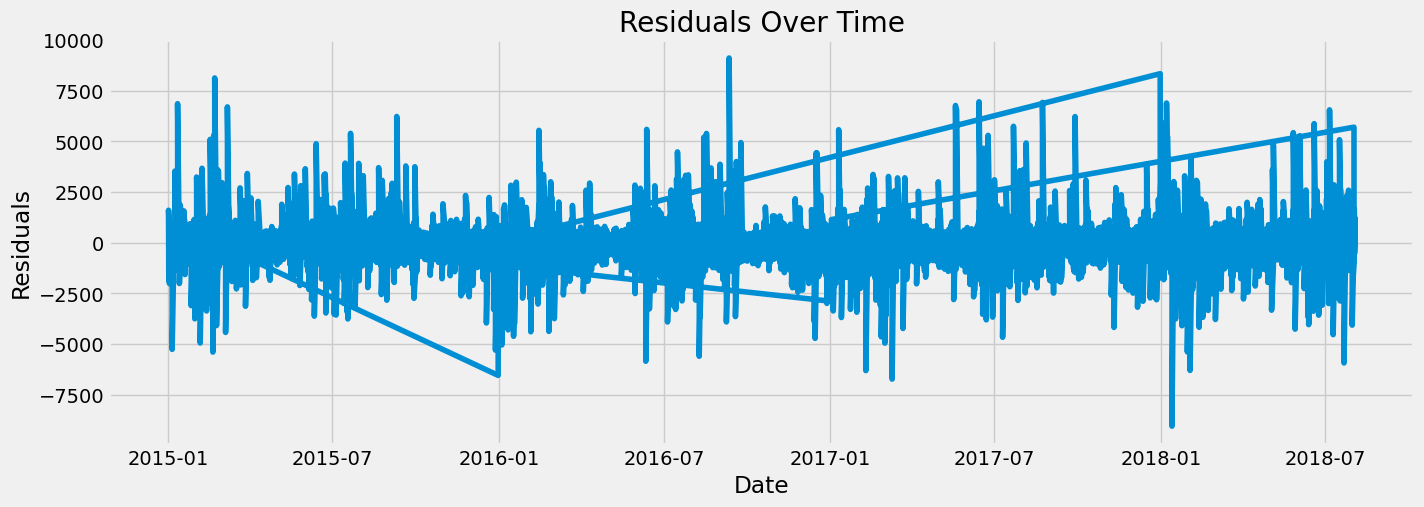

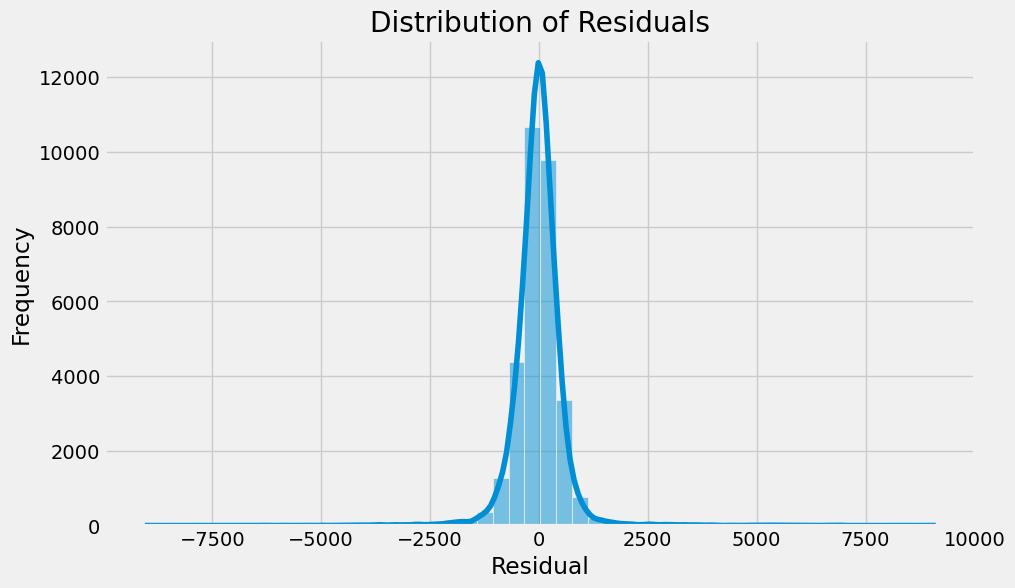

In [13]:
# Plot residuals over time
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['residuals'], label='Residuals')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(test['residuals'], bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()
